# About: Run Container on AWS ECS

このNotebookは、このイメージ `yacchin1205/jupyter-with-jenkins` をECSで動作させるNotebookの例です。

本手順は、 *Tutorial: Creating a Cluster with a Fargate Task Using the AWS CLI* https://docs.aws.amazon.com/AmazonECS/latest/developerguide/ECS_AWSCLI_Fargate.html をJupyter Notebookにて記述したものです。

# Prerequisites

このNotebookを利用するためにはいくつかの前提条件があります。**以下の説明を読みながら、必要なアカウント等の設定を行って**ください。

## 事前条件

**事前にTerminalから、 `aws configure` を実施してください。**

`aws configure` の実施例:

```
$ aws configure
AWS Access Key ID [None]: (自身のアカウントのアクセスキー)
AWS Secret Access Key [None]: (自身のアカウントのシークレットアクセスキー)
Default region name [None]: ap-northeast-1 (使用したいリージョン)
Default output format [None]: json (jsonを指定)
```

アクセスキー管理方法は様々ありますが、AWS IAMのユーザー https://console.aws.amazon.com/iam/home?region=us-west-2#/users からNotebook用のユーザーを作成する方法があります。万が一アクセスキーが漏れた場合に備えて、権限を最小限に、いつでも無効化できるように設定する必要があります。

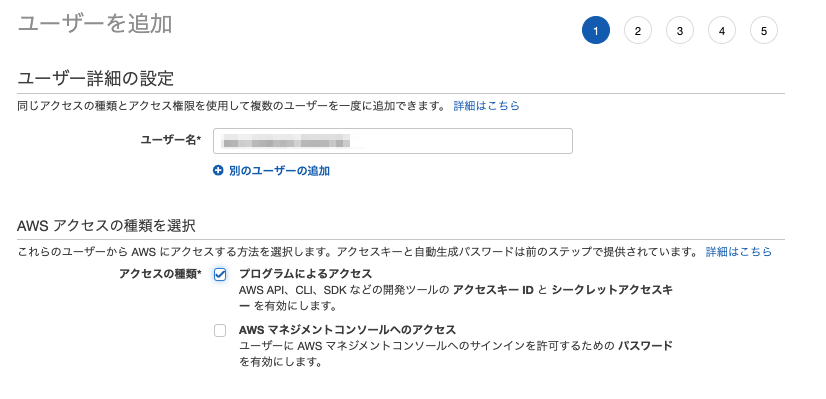

権限は `AmazonEC2FullAccess`, `AmazonElasticFileSystemFullAccess`,  `AmazonECS_FullAccess`, `AWSCloudFormationFullAccess`, `CloudWatchFullAccess` を想定しています。

正しくアクセス情報が指定されているかどうかを、`describe-vpcs`により確認します。**以下のコマンド実行がエラーとなる場合、`aws configure`が正しくなされていない可能性があります。**

In [ ]:
import json
import sys

vpc_result = !aws ec2 describe-vpcs
try:
    vpcs = json.loads('\n'.join(vpc_result))['Vpcs']
    print('{} VPCs exist'.format(len(vpcs)))
except:
    print(vpc_result)
    raise sys.exc_info()

## Prepare VPC

In [ ]:
cloudformation_stack_name = 'ecstest0001'
cloudformation_stack_name

In [ ]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

### Templateの定義

In [ ]:
%%writefile {work_dir}/template.yml
AWSTemplateFormatVersion: "2010-09-09"
Description: 'A VPC for ECS'
Resources:
  VPC:
    Type: "AWS::EC2::VPC"
    Properties:
      CidrBlock: 10.1.0.0/16
      EnableDnsSupport: true
      EnableDnsHostnames: true
      Tags:
      - Key: Name
        Value:  !Join ['', [!Ref "AWS::StackName", "-VPC" ]]
            
  InternetGateway:
    Type: "AWS::EC2::InternetGateway"
    DependsOn: VPC
        
  AttachGateway:
    Type: "AWS::EC2::VPCGatewayAttachment"
    Properties:
      VpcId: !Ref VPC
      InternetGatewayId: !Ref InternetGateway
        
  ECSSubnet:
    Type: AWS::EC2::Subnet
    Properties:
      VpcId: !Ref VPC
      CidrBlock: 10.1.1.0/24
      AvailabilityZone: !Select [ 0, !GetAZs ]    # Get the first AZ in the list       
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-ECS
                
  ECSPublicRouteTable:
    Type: AWS::EC2::RouteTable
    Properties:
      VpcId: !Ref VPC
      Tags:
      - Key: Name
        Value: ECSPublic

  ECSRoute1:
    Type: AWS::EC2::Route
    DependsOn: AttachGateway
    Properties:
      RouteTableId: !Ref ECSPublicRouteTable
      DestinationCidrBlock: 0.0.0.0/0
      GatewayId: !Ref InternetGateway  
        
  ECSPublicRouteTableAssociation:
    Type: AWS::EC2::SubnetRouteTableAssociation
    Properties:
      SubnetId: !Ref ECSSubnet
      RouteTableId: !Ref ECSPublicRouteTable
        
  ECSSecurityGroup:
    Type: AWS::EC2::SecurityGroup
    Properties:
      GroupDescription: security group for ECS
      VpcId: !Ref VPC
      Tags:
      - Key: Name
        Value: !Sub ${AWS::StackName}-ECSSG

Outputs:
  ECSVPC:
    Value: !Ref VPC

  ECSSubnet:
    Value: !Ref ECSSubnet

  ECSSecurityGroup:
    Value: !Ref ECSSecurityGroup

### Stackの作成

Cloud FormationのStackを作成します。

In [ ]:
stack_result = !aws cloudformation create-stack --stack-name {cloudformation_stack_name} \
    --template-body file://{work_dir}/template.yml
try:
    stack_id = json.loads('\n'.join(stack_result))['StackId']
    print('StackId', stack_id)
except:
    print(stack_result)
    raise sys.exc_info()

以下のセルの実行結果に表示されるURLをクリックして、作成状況を確認してください。ステータスがCREATE_COMPLETEとなれば、Stackの作成は成功です。

In [ ]:
import urllib.parse
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/cloudformation/home#/stacks/stackinfo?stackId={stack_id}'.format(region=regions[0], stack_id=urllib.parse.quote(stack_id)))

**ステータスがCREATE_COMPLETEに変化したことを確認**したら、以下のセルを実行してください。

> 以下のセルは、Stack作成中の場合はエラーとなります。

In [ ]:
describe_stack_result = !aws cloudformation describe-stacks --stack-name {stack_id}
stack_desc = json.loads(''.join(describe_stack_result))['Stacks'][0]
assert stack_desc['StackStatus'] == 'CREATE_COMPLETE', stack_desc['StackStatus']

# Step 1: Create a Cluster

In [ ]:
cluster_name = 'fargate-cluster'
cluster_name

In [ ]:
cluster_result = !aws ecs create-cluster --cluster-name {cluster_name}
try:
    cluster_info = json.loads(''.join(cluster_result))
    print(cluster_info)
except:
    print(cluster_result)
    raise sys.exc_info()

# Step 2: Register a Task Definition

## EFSの準備

In [ ]:
efs_result = !aws efs create-file-system
efs_info = json.loads(''.join(efs_result))
efs_info

In [ ]:
subnet_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'ECSSubnet'][0]
security_group_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'ECSSecurityGroup'][0]
(subnet_id, security_group_id)

In [ ]:
mount_target_result = !aws efs create-mount-target \
  --file-system-id {efs_info['FileSystemId']} \
  --subnet-id  {subnet_id} \
  --security-group {security_group_id}
mount_info = json.loads(''.join(mount_target_result))
mount_info

## 定義の準備

In [ ]:
container_image = 'yacchin1205/jupyter-with-jenkins'
log_group_name = '/ecs/jupyter'
log_stream_prefix = 'jupyter-with-jenkins'
(container_image, log_group_name, log_stream_prefix)

In [ ]:
import IPython

print('Jupyterへのアクセスに用いるパスワードを設定してください。')
password_hash = IPython.lib.passwd()
password_hash

In [ ]:
task_def = {
    "family": "sample-fargate", 
    "networkMode": "awsvpc", 
    "containerDefinitions": [
        {
            "name": "jupyter", 
            "image": container_image, 
            "portMappings": [
                {
                    "containerPort": 8888, 
                    "hostPort": 8888, 
                    "protocol": "tcp"
                }
            ],
            "essential": True,
            'environment': [
                {
                    'name': 'CHOWN_HOME',
                    'value': 'yes'
                },
                {
                    'name': 'GRANT_SUDO',
                    'value': 'yes'
                },
            ],
            'user': '0',
            "mountPoints": [
                {
                    "containerPath": "/home/jovyan",
                    "sourceVolume": "efs-jupyter"
                }
            ],
            "command": ["start-notebook.sh", '--NotebookApp.password=' + password_hash],
        }
    ], 
    "requiresCompatibilities": [
        "FARGATE"
    ],
    "volumes": [
        {
            "name": "efs-jupyter",
            "efsVolumeConfiguration": {
                "fileSystemId": efs_info['FileSystemId'],
            }
        }
    ],
    "cpu": "1024", 
    "memory": "4096"
}
task_def

In [ ]:
import os
taskdef_path = os.path.join(work_dir, 'taskdef.json')
with open(taskdef_path, 'w') as f:
    f.write(json.dumps(task_def))
!cat {taskdef_path}

In [ ]:
taskdef_result = !aws ecs register-task-definition --cli-input-json file://{taskdef_path}
try:
    taskdef_info = json.loads(''.join(taskdef_result))
    taskdef_arn = taskdef_info['taskDefinition']['taskDefinitionArn']
    print(taskdef_arn)
except:
    print(taskdef_result)
    raise sys.exc_info()

# Step 3: List Task Definitions

In [ ]:
!aws ecs list-task-definitions

# Step 4: Create a Service

In [ ]:
service_name = 'fargate-service3'
service_name

In [ ]:
subnet_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'ECSSubnet'][0]
security_group_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'ECSSecurityGroup'][0]
(subnet_id, security_group_id)

In [ ]:
network_configuration = 'awsvpcConfiguration={{subnets=[{subnet_id}],securityGroups=[{security_group_id}],assignPublicIp=ENABLED}}'.format(**locals())
service_result = !aws ecs create-service --cluster {cluster_name} --platform-version 1.4.0 --service-name {service_name} --task-definition {taskdef_arn} --desired-count 1 --launch-type "FARGATE" --network-configuration "{network_configuration}"
try:
    service_info = json.loads(''.join(service_result))
    print(service_info)
except:
    print(service_result)
    raise sys.exc_info()

# Step 6: Describe the Running Service

In [ ]:
service_desc_result = !aws ecs describe-services --cluster {cluster_name} --services {service_name}
service_desc_info = json.loads(''.join(service_desc_result))
service_desc_info

# Accessing to the service

In [ ]:
import re

service_pattern = re.compile(r'.*\s+started\s*([0-9]+)\s*tasks:\s*\(task\s+(.+)\).*')

service_result = !aws ecs describe-services --cluster {cluster_name} --services {service_name}
service_info = json.loads(''.join(service_result))
events = [event['message'] for event in service_info['services'][0]['events'] if service_pattern.match(event['message'])]
assert len(events) > 0, service_info['services'][0]['events']
task_id = service_pattern.match(events[0]).group(2)
task_id

In [ ]:
task_result = !aws ecs describe-tasks --cluster {cluster_name} --task {task_id}
task_info = json.loads(''.join(task_result))
assert task_info['tasks'][0]['lastStatus'] == 'RUNNING', task_info['tasks'][0]['lastStatus']
task_info['tasks'][0]['attachments']

In [ ]:
network_info = dict([(detail['name'], detail['value']) for detail in task_info['tasks'][0]['attachments'][0]['details']])
eniid = network_info['networkInterfaceId']
eniid

In [ ]:
network_desc = !aws ec2 describe-network-interfaces --network-interface-ids {eniid}
network_info = json.loads(''.join(network_desc))
public_ip = network_info['NetworkInterfaces'][0]['Association']['PublicIp']
public_ip

## Security Groupの変更

JupyterへのアクセスにはTCPポート8888を使用する。自身の環境からコンテナへのアクセスを許可するよう適切なポートおよびアクセス元IPアドレスを指定する。**インバウンドルールを編集**ボタンを選択して、以下のようなルールを追加する。

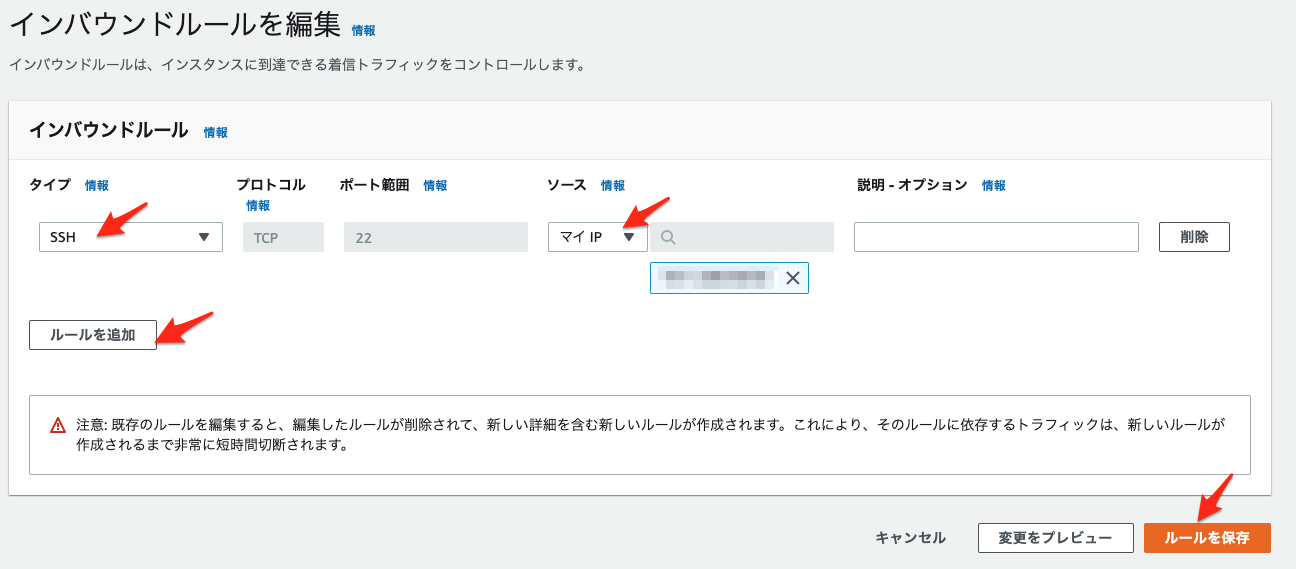

Security GroupのIDはStackのOutputsに記録されている。

In [ ]:
stack_desc['Outputs']

In [ ]:
security_group_id = [o['OutputValue'] for o in stack_desc['Outputs'] if o['OutputKey'] == 'ECSSecurityGroup'][0]
security_group_id

In [ ]:
regions = !aws configure get region
print('https://{region}.console.aws.amazon.com/ec2/v2/home?region={region}#SecurityGroup:groupId={security_group_id}'.format(region=regions[0], security_group_id=security_group_id))

In [ ]:
# セキュリティグループにSSHに関する許可が含まれていれば先に進める
sg_result = !aws ec2 describe-security-groups --group-ids {security_group_id}
sg_desc = json.loads(''.join(sg_result))['SecurityGroups'][0]

assert 'IpPermissions' in sg_desc and any([ipperm['IpProtocol'] == 'tcp' and ipperm['ToPort'] <= 8888 and 8888 <= ipperm['FromPort'] for ipperm in sg_desc['IpPermissions']]), sg_desc['IpPermissions']